<a href="https://colab.research.google.com/github/andcetera/deep-learning-challenge/blob/main/AlphabetSoupCharity_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

# Connect to Google Drive to access dataset file
from google.colab import drive
drive.mount('/content/drive')

#  Import and read the charity_data.csv.
import pandas as pd 
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/charity_data.csv")
df.head()

Mounted at /content/drive


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Checking balance of Active/Inactive applications
df['STATUS'].value_counts()

1    34294
0        5
Name: STATUS, dtype: int64

In [3]:
# Checking counts of applications with Special Considerations
df['SPECIAL_CONSIDERATIONS'].value_counts()

N    34272
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

In [4]:
# Removing Inactive applications and those with Special Considerations to focus on generalizable predictions
df_reduced = df.loc[(df['SPECIAL_CONSIDERATIONS'] == 'N') & (df['STATUS']==1), :]
display(df_reduced['STATUS'].value_counts())
display(df_reduced['SPECIAL_CONSIDERATIONS'].value_counts())

1    34268
Name: STATUS, dtype: int64

N    34268
Name: SPECIAL_CONSIDERATIONS, dtype: int64

In [5]:
# Drop the non-beneficial ID columns: 'EIN' and 'NAME' & reduced columns: 'STATUS' and 'SPECIAL_CONSIDERATIONS'
apps = df_reduced.drop(columns=['EIN', 'NAME', 'STATUS', 'SPECIAL_CONSIDERATIONS'])

# Checking number of unique values in remaining columns
apps.nunique()

APPLICATION_TYPE      17
AFFILIATION            6
CLASSIFICATION        71
USE_CASE               5
ORGANIZATION           4
INCOME_AMT             9
ASK_AMT             8741
IS_SUCCESSFUL          2
dtype: int64

In [6]:
app_type = apps['APPLICATION_TYPE'].value_counts()

# Choose a different cutoff value and create a list of application types to be replaced
application_types_to_replace = [app for app in app_type.index if app_type[app] < 1000]

# Replace in dataframe
for app in application_types_to_replace:
    apps['APPLICATION_TYPE'] = apps['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
apps['APPLICATION_TYPE'].value_counts()

T3       27006
Other     2266
T4        1542
T6        1216
T5        1173
T19       1065
Name: APPLICATION_TYPE, dtype: int64

In [7]:
class_types = apps['CLASSIFICATION'].value_counts()

# Choose a different cutoff value and create a list of classifications to be replaced
classifications_to_replace = [cls for cls in class_types.index if class_types[cls] < 4000]

# Replace in dataframe
for cls in classifications_to_replace:
    apps['CLASSIFICATION'] = apps['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
apps['CLASSIFICATION'].value_counts()

C1000    17307
C2000     6069
Other     6059
C1200     4833
Name: CLASSIFICATION, dtype: int64

In [8]:
# Convert categorical data to numeric with `pd.get_dummies`
income = pd.get_dummies(apps['INCOME_AMT'], drop_first=True, prefix='INC')
affil = pd.get_dummies(apps['AFFILIATION'], drop_first=True, prefix='AFFIL')
use_case = pd.get_dummies(apps['USE_CASE'], drop_first=True, prefix='USE')
org = pd.get_dummies(apps['ORGANIZATION'], drop_first=True, prefix='ORG')
app_type = pd.get_dummies(apps['APPLICATION_TYPE'], drop_first=True, prefix='APP')
class_type = pd.get_dummies(apps['CLASSIFICATION'], drop_first=True, prefix='CLASS')
data = apps[['ASK_AMT', 'IS_SUCCESSFUL']]
data = pd.concat([data, income, affil, use_case, org, app_type, class_type], axis=1)
data.head()

,ASK_AMT,IS_SUCCESSFUL,INC_1-9999,INC_10000-24999,INC_100000-499999,INC_10M-50M,INC_1M-5M,INC_25000-99999,INC_50M+,INC_5M-10M,...,ORG_Corporation,ORG_Trust,APP_T19,APP_T3,APP_T4,APP_T5,APP_T6,CLASS_C1200,CLASS_C2000,CLASS_Other
0,5000,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108590,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,5000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,6692,1,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
4,142590,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [9]:
# Split the preprocessed data into features and target arrays
y = data['IS_SUCCESSFUL'].values.reshape(-1, 1)
X = data.drop('IS_SUCCESSFUL', axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [10]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [31]:
# Define the number of features for the input layer, and max nodes for each hidden layer
input = X_train.shape[1]
layer_1 = 100
layer_2 = 80
layer_3 = 50

model2 = tf.keras.models.Sequential()

# First hidden layer
model2.add(tf.keras.layers.Dense(units=layer_1, activation='relu', input_dim=input))

# additional hidden layers
model2.add(tf.keras.layers.Dense(units=layer_2, activation='relu'))

model2.add(tf.keras.layers.Dense(units=layer_3, activation='relu'))

# Output layer
model2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 100)               3000      
                                                                 
 dense_22 (Dense)            (None, 80)                8080      
                                                                 
 dense_23 (Dense)            (None, 50)                4050      
                                                                 
 dense_24 (Dense)            (None, 1)                 51        
                                                                 
Total params: 15,181
Trainable params: 15,181
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cb = tf.keras.callbacks.ModelCheckpoint(filepath='weights_{epoch:03d}.h5', save_weights_only=True, period=5)

In [33]:
# Train the model
fit_model = model2.fit(X_train_scaled, y_train, epochs=75, callbacks=[cb])

Epoch 1/75
804/804 [==============================] - 4s 2ms/step - loss: 0.5757 - accuracy: 0.7198
Epoch 2/75
804/804 [==============================] - 3s 3ms/step - loss: 0.5622 - accuracy: 0.7260
Epoch 3/75
804/804 [==============================] - 3s 3ms/step - loss: 0.5592 - accuracy: 0.7289
Epoch 4/75
804/804 [==============================] - 2s 2ms/step - loss: 0.5583 - accuracy: 0.7307
Epoch 5/75
804/804 [==============================] - 2s 2ms/step - loss: 0.5565 - accuracy: 0.7309
Epoch 6/75
804/804 [==============================] - 2s 2ms/step - loss: 0.5561 - accuracy: 0.7316
Epoch 7/75
804/804 [==============================] - 2s 2ms/step - loss: 0.5557 - accuracy: 0.7329
Epoch 8/75
804/804 [==============================] - 2s 2ms/step - loss: 0.5549 - accuracy: 0.7321
Epoch 9/75
804/804 [==============================] - 2s 3ms/step - loss: 0.5544 - accuracy: 0.7325
Epoch 10/75
804/804 [==============================] - 3s 3ms/step - loss: 0.5538 - accuracy: 0.7338

In [34]:
# Evaluate the model using the test data
model_loss, model_accuracy = model2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5758 - accuracy: 0.7244 - 574ms/epoch - 2ms/step
Loss: 0.5758417844772339, Accuracy: 0.7244076132774353


<Axes: >

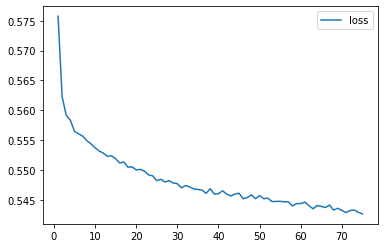

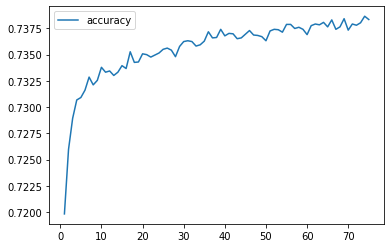

In [35]:
# Create a DataFrame containing training history
hist = pd.DataFrame(fit_model.history)
hist.index += 1
# Plot the accuracy
hist.plot(y="loss")
hist.plot(y='accuracy')

In [36]:
# Export our model to HDF5 file
model2.save('AlphabetSoupCharity_Optimization.h5')

In [37]:
1 - sum(y)/len(y)

array([0.46766663])